In [2]:
"""
cGAN for binary classification of Attack vs Benign
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate, LSTM
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
import keras
from sklearn.utils import shuffle

import time

In [3]:
np.random.seed(42)

In [4]:
class cGAN():
    
    """
    The code for Conditional GAN (cGAN) class with methods for
        discriminator and generator networks
        and their training

    """
    
    def __init__(self,latent_dim=32, out_shape=80):
        
        self.latent_dim = latent_dim
        self.out_shape = out_shape 
        self.num_classes = 2
        # using Adam as our optimizer
        optimizer = Adam(0.0002, 0.5)
        
        # building the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # building the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])
        
        # we don't train discriminator when training generator
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])


    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        
        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")

    
    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(1, activation='sigmoid'))
        
        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True): 
        
        # global losses to track performance
        global G_losses
        global D_losses
        
        G_losses = []
        D_losses = []

        lowest = 100000000

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            start = time.time()
            
            # for training with sampling use 8 samples from postive class and the remainder from negative class
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size-8)
                idx = np.concatenate((idx1, idx0))
            # without sampling train discriminator with random instances
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)
            
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid 
                fake_smooth = fake
                
            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            if abs(d_loss[0]) < lowest:
                lowest = abs(d_loss[0].copy())
                self.discriminator.save_weights('./checkpoint')
                print("Saved model to CWD.")
            
            # Train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            end = time.time()

            timeTaken = round(end - start, 3)

            print('[%d/%d]\t Time: %.4f \t Loss_D: %.4f\tLoss_G: %.4f'
                % (epoch, epochs, timeTaken, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

In [5]:
# Model Performance Metrics

def test(model,X_test,y_test,y_pred, deep=True):
    if(deep==True): 
        score = model.evaluate([X_test, y_test],np.ones(len(y_test)), verbose=1)

        print(score)
    
    # Accuracy 
    acc = accuracy_score(y_test, y_pred)
    print('\nAccuracy')
    print(acc)
    
    # Precision 
    prec = precision_score(y_test, y_pred)#,average='macro')
    print('\nPrecision')
    print(prec)
    
    # Recall
    rec = recall_score(y_test, y_pred) #,average='macro')
    print('\nRecall')
    print(rec)
    
    # F1 score
    f1 = f1_score(y_test,y_pred) #,average='macro')
    print('\nF1 Score')
    print(f1)
    
    return acc, prec, rec, f1

c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 2s 2s/step
Saved model to CWD.
[0/2000]	 Time: 3.7870 	 Loss_D: 0.6937	Loss_G: 0.6923
1/1 [==============================] - 0s 14ms/step
Saved model to CWD.
[1/2000]	 Time: 0.1210 	 Loss_D: 0.6932	Loss_G: 0.6922
1/1 [==============================] - 0s 16ms/step
Saved model to CWD.
[2/2000]	 Time: 0.1380 	 Loss_D: 0.6932	Loss_G: 0.6922
1/1 [==============================] - 0s 14ms/step
Saved model to CWD.
[3/2000]	 Time: 0.1230 	 Loss_D: 0.6930	Loss_G: 0.6920
1/1 [==============================] - 0s 14ms/step
Saved model to CWD.
[4/2000]	 Time: 0.1150 	 Loss_D: 0.6929	Loss_G: 0.6918
1/1 [==============================] - 0s 15ms/step
Saved model to CWD.
[5/2000]	 Time: 0.1200 	 Loss_D: 0.6928	Loss_G: 0.6916
1/1 [==============================] - 0s 18ms/step
Saved model to CWD.
[6/2000]	 Time: 0.1200 	 Loss_D: 0.6928	Loss_G: 0.6915
1/1 [==============================] - 0s 17ms/step
Saved model to CWD.
[7/2000]	 Time: 0.1340 	 Loss_D: 0.6926	L

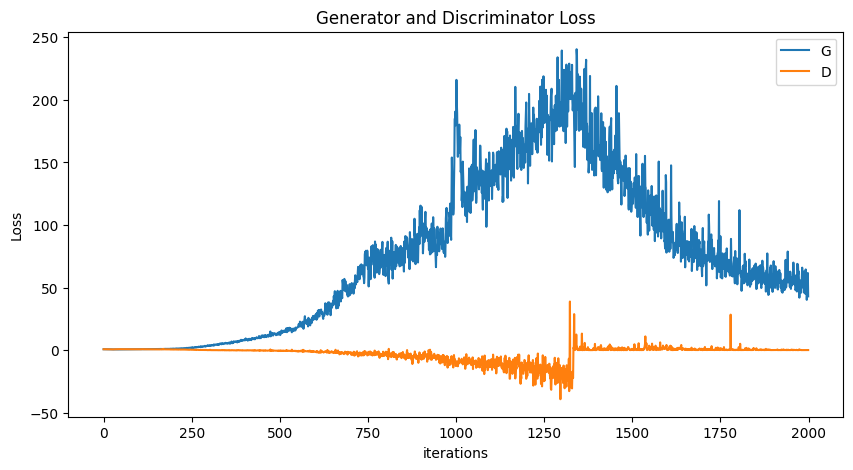

In [6]:
df_bin = pd.read_csv("binary_v2.csv")
df_bin['label'] = df_bin[' Label'].apply(lambda l : 0 if l == 'BENIGN' else 1)
df_bin.reset_index(drop=True, inplace=True)
df_bin.head()

df_bin.columns

scaler = StandardScaler()
X = df_bin.drop([" Label","label"], axis=1)
y = df_bin['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

cgan = cGAN()

y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=2000)
cgan.discriminator.save('discriminator_test.h5')

In [8]:
#load saved model and evaluate on test set
reconstructed_model = keras.models.load_model("discriminator_test.h5")
reconstructed_model.load_weights('./checkpoint')
y_pred_prob = reconstructed_model.predict([X_test, y_test])

"""
Since the discriminator prediction outputs the probability of each sample being a real instance of the provided label,
we inspect the results and assign predicted labels based on the given probability.

Originally I was just inputting an array of 1's to get the probability of the samples being 1's and doing a threshold of 0.5
to determine predictions, but this misses cases where it would have ie: a 50% probability of being a real 1 and a 70% probability of being a real zero (boundary cases)

This method addresses that.
"""
y_pred = [0] * len(y_pred_prob)

for i, elem in enumerate(y_pred_prob):
    if elem >= 0.5:
        y_pred[i] = y_test[i]
    else:
        y_pred[i] = abs(y_test[i] - 1)
        
acc, prec, rec, f1 = test(reconstructed_model,X_test,y_test,y_pred)
print("Accuracy :", acc)
print("Precision :", prec)
print("Recall :", rec)
print("F1 Score :", f1)

c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1250/1250 [==============================] - 3s 2ms/step - loss: 1.0178 - accuracy: 0.9889
[1.0177735090255737, 0.9888997077941895]

Accuracy
0.9888997224930623

Precision
0.9872446437468859

Recall
0.9906009399060094

F1 Score
0.9889199441006189
Accuracy : 0.9888997224930623
Precision : 0.9872446437468859
Recall : 0.9906009399060094
F1 Score : 0.9889199441006189
